In [1]:
from irbasis_util.four_point_ph_view import *
from irbasis_util.internal import *
from irbasis_util.regression import *
from irbasis_util.tensor_regression import *
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#padding on the y axis between label and axis
plt.rcParams['ytick.major.pad']='10'

dpi_out = 400
fig_width = 3.39
golden_mean = (np.sqrt(5)-1.0)/2.0    # Aesthetic ratio
fig_height = fig_width*golden_mean # height in inches
MAX_HEIGHT_INCHES = 8.0
if fig_height > MAX_HEIGHT_INCHES:
    print("WARNING: fig_height too large:" + fig_height + 
          "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
    fig_height = MAX_HEIGHT_INCHES
#fig, ax = plt.subplots(figsize = (fig_width, fig_height), frameon=True)
small_tick_size = 8
small_label_size = 8

In [3]:
# Implementation of Rohringer et al. () 2012)
def _delta(i, j):
    if i==j:
        return 1
    else:
        return 0

def _F_ph(U, beta, n, np, m):
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    r1 = nu + omega
    r2 = nu_p + omega
    tmp = 1. / (nu * r1 * r2 * nu_p)
    Fuu = (-0.25 * beta * (U**2) * (_delta(n,np) - _delta(m,0)) *
               (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    t1 = 0.125 * (U**3) * (nu**2 + r1**2 + r2**2 + nu_p**2) * tmp
    t2 = (3.0 / 16.0) * (U**5) * tmp
    t3 = (beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(0.5 * beta * U)))
              * (2 * _delta(nu, -nu_p - m) + _delta(m, 0)) *
              (1 + 0.25 * (U / r1)**2) * (1 + 0.25 * (U / r2)**2))
    t4 = (-beta * 0.25 * (U**2) *
              (1 / (1 + numpy.exp(-0.5 * beta * U)))
              * (2 * _delta(nu, nu_p) + _delta(m, 0)) *
              (1 + 0.25 * (U / nu)**2) * (1 + 0.25 * (U / r2)**2))
    Fud = -U + t1 + t2 + t3 + t4
    return Fuu, Fud

def _G2_conn_ph(U, beta, n, np, m):
    Fuu, Fud = _F_ph(U, beta, n, np, m)
    nu = (2 * n + 1) * numpy.pi / beta
    nu_p = (2 * np + 1) * numpy.pi / beta
    omega = 2 * m * numpy.pi / beta
    hU = 0.5 * U
    leggs_1 = nu * (nu + omega) * nu_p * (nu_p + omega)
    leggs_2 = ((hU**2 + nu**2) * (hU**2 + nu_p**2) *
                   (hU**2 + (nu + omega)**2) * (hU**2 + (nu_p + omega)**2))
    leggs = leggs_1 / leggs_2
    return (leggs * Fuu + leggs * Fud)

In [10]:
def elbow_method(alphas, squared_errors):
    """
    
    Parameters
    ----------
    alphas    regularization parameters in ascending order
    squared_errors  corresponding squared_errors

    Returns index of optimal value of alpha in alphas
    -------

    """
    x = numpy.log(alphas)
    y = numpy.log(squared_errors)
    
    a = (y[-1] - y[0])/(x[-1] - x[0])
    y -= a * (x - x[0]) + y[0]
    
    r = numpy.argmin(y)
    if isinstance(r, numpy.int64):
        return r
    else:
        return r[0]

# Regression with multiple values of alpha
def kruskal_complex_alphas(tensors_A, y, alphas, rank):
    """
    
    Parameters
    ----------
    A
    y
    alphas  regularization parameters in ascending order

    Returns
    -------
    
     Nw, Nr, freq_dim, linear_dim, tensors_A, y, alpha, D):

    """
    coeffs_alpha = []
    squared_errors_alpha = []
    Nw, Nr, linear_dim = tensors_A[0].shape
    print(Nw, Nr, linear_dim)
    for alpha in alphas:
        #print(tensors_A)
        #print(y)
        model = OvercompleteGFModel(Nw, Nr, 2, linear_dim, tensors_A, y, alpha, rank)
        optimize(model, 10000, learning_rate = 0.1, tol_rmse = 1e-8, verbose = 1)
        coeffs = model.full_tensor_x().numpy()
        coeffs_alpha.append(coeffs)
        e = model.mse().numpy()
        print("alpha = ", alpha, e)
        squared_errors_alpha.append(e)
    
    squared_errors_alpha = numpy.array(squared_errors_alpha)
        
    # Choose optimal alpha using Elbow method 
    opt_idx = elbow_method(alphas, squared_errors_alpha)
    
    return coeffs_alpha, squared_errors_alpha, opt_idx

In [5]:
boson_freq = 10
Lambda = 100.0
beta = 5.0
U = 2.0
wmax = Lambda / beta
rank = 10

numpy.random.seed(100)
#noise = 0.0012
# 2% error
noise = 1e-3

In [6]:
#alpha = 1e-15
augmented = True
phb = FourPointPHView(boson_freq, Lambda, beta, 1e-5, augmented)
Nl = phb.Nl
whichl = Nl - 1
print("Nl", Nl)
# build the sampling frequency structure
sp = phb.sampling_points_matsubara(whichl)
#print(S.shape)
n_sp = len(sp)

Nl 19


In [7]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
# S: [(3, 2, 2, Nl), (3, 2, 2, Nl)]
# prj = S * prj
def construct_prj(sp):
    n_sp = len(sp)
    prj = phb.projector_to_matsubara_vec(sp, decomposed_form=True)
    S = phb.normalized_S(decomposed_form=True)
    for i in range(2):
        prj[i] *= S[i][None, :, :, :, :]
        prj[i] = prj[i].reshape((n_sp, 12, Nl))
    return prj
prj = construct_prj(sp)

# Build the check frequency structure
n1n2_check = []
niw = 100
niw_hf = 10000
wide_niw_check = numpy.hstack((range(-niw_hf, -niw, 500), range(-niw, niw, 10), range(niw, niw_hf, 500)))
for i, j in product(wide_niw_check, repeat=2):
    n1n2_check.append((i, j))
prj_check = construct_prj(n1n2_check)

numpy.random.seed(100)
Giwn = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in sp])
print ("adding noise")
noise_iwn = numpy.random.normal(loc=0.0, scale=noise, size=(len(sp)))
Giwn = noise_iwn + Giwn
#print(Giwn.imag)

adding noise


In [11]:
#alphas = [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
alphas = [10, 1, 1e-1, 1e-2]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 10, 100]
#alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 5e-1, 1, 2, 10, 100]
%time coeffs_alpha, se_alpha, opt_alpha_idx = kruskal_complex_alphas(prj, Giwn, alphas, rank)

2736 12 19
epoch =  0  loss =  254.5040421019355  mse= 8.06798241408247
epoch =  50  loss =  9.312362825305961e-06  mse= 8.578259370226427e-06
epoch =  100  loss =  8.9044372207873e-06  mse= 8.600267519235983e-06
epoch =  150  loss =  8.896691150641348e-06  mse= 8.585735152576708e-06
epoch =  200  loss =  8.889014000840439e-06  mse= 8.570784801077783e-06
epoch =  250  loss =  8.880964262874917e-06  mse= 8.56020627155835e-06
epoch =  300  loss =  8.872469798683492e-06  mse= 8.54466360899687e-06
epoch =  350  loss =  8.86359283848396e-06  mse= 8.52846947661117e-06
epoch =  400  loss =  8.854323543825956e-06  mse= 8.511611614105951e-06
epoch =  450  loss =  8.84465510646921e-06  mse= 8.494082135776477e-06
epoch =  500  loss =  8.834585228131539e-06  mse= 8.475878267979269e-06
epoch =  550  loss =  8.824118319578665e-06  mse= 8.457003420871925e-06
epoch =  600  loss =  8.813268854057867e-06  mse= 8.437468387242699e-06
epoch =  650  loss =  8.801844140417274e-06  mse= 8.413424302120313e-06


epoch =  5650  loss =  5.72669148457808e-06  mse= 4.195838218785439e-06
epoch =  5700  loss =  5.6936542409075545e-06  mse= 4.163748359442702e-06
epoch =  5750  loss =  5.661261733582215e-06  mse= 4.1324984864903106e-06
epoch =  5800  loss =  5.6295252153391416e-06  mse= 4.102075294416281e-06
epoch =  5850  loss =  5.598462793965854e-06  mse= 4.072466545660198e-06
epoch =  5900  loss =  5.568103932475906e-06  mse= 4.0436621869300275e-06
epoch =  5950  loss =  5.538496401758859e-06  mse= 4.015654985108021e-06
epoch =  6000  loss =  5.5092585772873355e-06  mse= 3.988435115000811e-06
epoch =  6050  loss =  5.480414133811854e-06  mse= 3.961560381751273e-06
epoch =  6100  loss =  5.452171892674117e-06  mse= 3.935356251882935e-06
epoch =  6150  loss =  5.424537776623497e-06  mse= 3.9097991732609926e-06
epoch =  6200  loss =  5.3975254711932575e-06  mse= 3.884864754352534e-06
epoch =  6250  loss =  5.371161024408983e-06  mse= 3.860528541785024e-06
epoch =  6300  loss =  5.345489958960252e-06 

epoch =  1250  loss =  1.9177439224938043e-05  mse= 3.068930760460121e-06
epoch =  1300  loss =  1.8124836153796573e-05  mse= 3.0465020051314882e-06
epoch =  1350  loss =  1.718923072616938e-05  mse= 3.014677323608772e-06
epoch =  1400  loss =  1.6350733129800094e-05  mse= 2.992829803142916e-06
epoch =  1450  loss =  1.5569235537647867e-05  mse= 2.992209212528429e-06
epoch =  1500  loss =  1.4869868155433479e-05  mse= 2.9631749007394914e-06
epoch =  1550  loss =  1.4236494643420538e-05  mse= 2.9439172334012747e-06
epoch =  1600  loss =  1.364085127695277e-05  mse= 2.9296954762999646e-06
epoch =  1650  loss =  1.310362693447001e-05  mse= 2.9132480132483834e-06
epoch =  1700  loss =  1.2613277629117949e-05  mse= 2.90124268831602e-06
epoch =  1750  loss =  1.2149350052655663e-05  mse= 2.903279546903162e-06
epoch =  1800  loss =  1.1727262786102025e-05  mse= 2.885414256363853e-06
epoch =  1850  loss =  1.1339740644793638e-05  mse= 2.873512075022327e-06
epoch =  1900  loss =  1.097183237455

epoch =  6850  loss =  4.2334904923384015e-06  mse= 2.656196550902706e-06
epoch =  6900  loss =  4.222810870357584e-06  mse= 2.6547016053503718e-06
epoch =  6950  loss =  4.212396890051614e-06  mse= 2.653412880122474e-06
epoch =  7000  loss =  4.202005316985852e-06  mse= 2.6513764393110075e-06
epoch =  7050  loss =  4.191799803156073e-06  mse= 2.650521382886311e-06
epoch =  7100  loss =  4.18189680396292e-06  mse= 2.6496181856057126e-06
epoch =  7150  loss =  4.1722036519713065e-06  mse= 2.648659436750868e-06
epoch =  7200  loss =  4.162402931032819e-06  mse= 2.6485216630220267e-06
epoch =  7250  loss =  4.152953963221403e-06  mse= 2.6470740970362822e-06
epoch =  7300  loss =  4.143729990552325e-06  mse= 2.6458154550173536e-06
epoch =  7350  loss =  4.134515897533272e-06  mse= 2.643837261917888e-06
epoch =  7400  loss =  4.125457344557207e-06  mse= 2.642992266299896e-06
epoch =  7450  loss =  4.11665807619234e-06  mse= 2.6420958914142238e-06
epoch =  7500  loss =  4.108036466611064e-06

epoch =  2400  loss =  1.4273870491453132e-06  mse= 1.1688633421399376e-06
epoch =  2450  loss =  1.4212434106817808e-06  mse= 1.1655263493501948e-06
epoch =  2500  loss =  1.4153106907420996e-06  mse= 1.1622962384525858e-06
epoch =  2550  loss =  1.4095750838554926e-06  mse= 1.1591691411664877e-06
epoch =  2600  loss =  1.4040227492153633e-06  mse= 1.1561412944627247e-06
epoch =  2650  loss =  1.3986501976760756e-06  mse= 1.153067542709052e-06
epoch =  2700  loss =  1.3935813670065331e-06  mse= 1.149735345504402e-06
epoch =  2750  loss =  1.3889156729405283e-06  mse= 1.147689115125481e-06
epoch =  2800  loss =  1.384461960259578e-06  mse= 1.1454174285942925e-06
epoch =  2850  loss =  1.380137461163639e-06  mse= 1.1431605173459782e-06
epoch =  2900  loss =  1.3759508874196907e-06  mse= 1.140849528505142e-06
epoch =  2950  loss =  1.3720488412939e-06  mse= 1.1390216548625237e-06
epoch =  3000  loss =  1.3682653728387778e-06  mse= 1.1371144684049297e-06
epoch =  3050  loss =  1.364579155

epoch =  7900  loss =  1.2399686381863415e-06  mse= 1.077576925517868e-06
epoch =  7950  loss =  1.239507299255888e-06  mse= 1.0773883067696865e-06
epoch =  8000  loss =  1.2390489114814031e-06  mse= 1.0771961771126508e-06
epoch =  8050  loss =  1.238593672377969e-06  mse= 1.0769987540447119e-06
epoch =  8100  loss =  1.2381425521918528e-06  mse= 1.0767905106811291e-06
epoch =  8150  loss =  1.2377001296463462e-06  mse= 1.076557968776752e-06
epoch =  8200  loss =  1.2372923122538414e-06  mse= 1.0762737781083094e-06
epoch =  8250  loss =  1.2368545740589964e-06  mse= 1.076299051642873e-06
epoch =  8300  loss =  1.2364169446281115e-06  mse= 1.0760646588166214e-06
epoch =  8350  loss =  1.2360283935944688e-06  mse= 1.0759783538602756e-06
epoch =  8400  loss =  1.2355923265969558e-06  mse= 1.075760038896721e-06
epoch =  8450  loss =  1.235202275674648e-06  mse= 1.075431030501557e-06
epoch =  8500  loss =  1.2347809364944723e-06  mse= 1.0754231516498159e-06
epoch =  8550  loss =  1.23440371

epoch =  3450  loss =  1.1723897234345248e-06  mse= 1.056534309308382e-06
epoch =  3500  loss =  1.1707470125307546e-06  mse= 1.0558987486091196e-06
epoch =  3550  loss =  1.1691439986607188e-06  mse= 1.0552821525717878e-06
epoch =  3600  loss =  1.1675964339626971e-06  mse= 1.0547037504408738e-06
epoch =  3650  loss =  1.166150986891114e-06  mse= 1.0541121149328716e-06
epoch =  3700  loss =  1.1646470032162443e-06  mse= 1.053533274330108e-06
epoch =  3750  loss =  1.1632137833281847e-06  mse= 1.053013403968819e-06
epoch =  3800  loss =  1.1618389256084385e-06  mse= 1.05243817078879e-06
epoch =  3850  loss =  1.1604484403766606e-06  mse= 1.0519235134865987e-06
epoch =  3900  loss =  1.1591439575686466e-06  mse= 1.0513899769166579e-06
epoch =  3950  loss =  1.1578270471191624e-06  mse= 1.0509180331333908e-06
epoch =  4000  loss =  1.1565554706912211e-06  mse= 1.0503860391719553e-06
epoch =  4050  loss =  1.1553455740776942e-06  mse= 1.0499096188121761e-06
epoch =  4100  loss =  1.154086

epoch =  8950  loss =  1.0965267888693395e-06  mse= 1.0269520096253985e-06
epoch =  9000  loss =  1.096238195762519e-06  mse= 1.026852663864262e-06
epoch =  9050  loss =  1.0959457037907921e-06  mse= 1.0267225315973854e-06
epoch =  9100  loss =  1.0956462512735752e-06  mse= 1.026608184292993e-06
epoch =  9150  loss =  1.0953613277645475e-06  mse= 1.026508245808539e-06
epoch =  9200  loss =  1.0950802769861036e-06  mse= 1.026386362545266e-06
epoch =  9250  loss =  1.0947887302259823e-06  mse= 1.0262760268408535e-06
epoch =  9300  loss =  1.0945242500846643e-06  mse= 1.0261699957902067e-06
epoch =  9350  loss =  1.0942351993521261e-06  mse= 1.0260590204307235e-06
epoch =  9400  loss =  1.0939593483668158e-06  mse= 1.025961456008176e-06
epoch =  9450  loss =  1.093691483869173e-06  mse= 1.0258473811894076e-06
epoch =  9500  loss =  1.0934151628864394e-06  mse= 1.0257463999387554e-06
epoch =  9550  loss =  1.093156126789615e-06  mse= 1.0256394960756643e-06
epoch =  9600  loss =  1.09288345

In [12]:
print(se_alpha)

[2.96908966e-06 2.59027377e-06 1.07139889e-06 1.02474848e-06]


In [2]:
plt.plot(alphas, se_alpha, marker='o')
plt.xlabel(r'$\alpha$')
plt.ylabel('Squared errors')
plt.xscale('log')
plt.yscale('log')
#plt.legend(loc='best')

NameError: name 'plt' is not defined

In [1]:
# OK, let us alpha = 0.1.
# An optimal value can be estimated by the elbow method (refer to the SpM paper by J. Otsuki et al.)
#alpha_best = 0.1
#opt_alpha_idx = 0
alpha_best = alphas[opt_alpha_idx]
print("best value of alpha", alpha_best)
#alpha_best = 0.1

coeffs = coeffs_alpha[opt_alpha_idx].reshape((3, 2, 2, Nl, Nl))
#print(coeffs.shape)

NameError: name 'alphas' is not defined

In [15]:
# prj: [(n_sp, 3, 2, 2, Nl), (n_sp, 3, 2, 2, Nl)]
def compute_Giwn(prj, coeff):
    niw = prj[0].shape[0]
    #print(prj[0].shape)
    prj_mat = numpy.einsum('nrl,nrm->nrlm', prj[0], prj[1]).reshape((niw, 3 * 2 * 2 * Nl * Nl))
    return prj_mat@coeffs.reshape((3 * 2 * 2 * Nl * Nl))

Giwn_check = compute_Giwn(prj_check, coeffs)
print(Giwn_check.shape)
Giwn_check_ref = numpy.array([_G2_conn_ph(U, beta, n1n2[0], n1n2[1], boson_freq) for n1n2 in n1n2_check])

diff = numpy.amax(numpy.abs(Giwn_check - Giwn_check_ref))
print(diff)
print(diff < 1e-3)

(3600,)
0.002353982417255476
False


[-0.00174977  0.00034258  0.00115282 ... -0.0005132  -0.0004395
 -0.00139515]


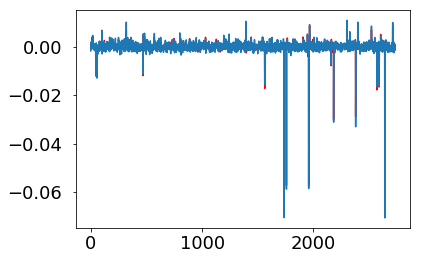

In [16]:
Giwn_reconst = compute_Giwn(prj, coeffs)
plt.plot(Giwn_reconst.real, c='r')
plt.plot(Giwn.real)
print(Giwn.real)

0.07012537833753249


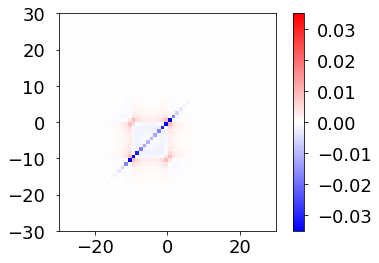

In [17]:
import matplotlib.pylab as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

N = 100
N_zoom = 30
#x = numpy.linspace(-N, N, 2*N+1)
x = numpy.arange(-N, N+1)
G2_conn_ph = numpy.zeros((2 * N + 1,2 * N + 1), dtype=float)

for i in range(2 * N + 1):
    for j in range(2 * N + 1):
        n = x[i]
        np = x[j]
        G2_conn_ph[i, j] = _G2_conn_ph(U, beta, n, np, boson_freq)

vrange = numpy.amax(numpy.abs(G2_conn_ph))
plt.imshow(G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()
print (vrange)

#plt.legend(loc='best',shadow=True,frameon=False)

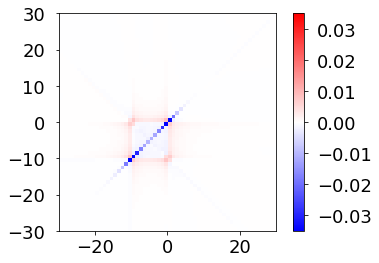

In [18]:
n1n2_check_2d = numpy.array([(x[i], x[j]) for i in range(2 * N + 1) for j in range(2 * N + 1)])
prj_check_2d = construct_prj(n1n2_check_2d)

Giwn_check = compute_Giwn(prj_check_2d, coeffs)
Giwn_check = Giwn_check.reshape((2 * N + 1, 2 * N + 1))
vrange = numpy.amax(numpy.abs(Giwn_check))
plt.imshow(Giwn_check.real.T[N - N_zoom: N + N_zoom, N - N_zoom: N + N_zoom],
           origin="lower", extent=(-N_zoom, N_zoom, -N_zoom, N_zoom), 
           cmap=cm.bwr, vmin=-vrange/ 2, vmax=vrange / 2
          )
plt.colorbar()

In [ ]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[:, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[:, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_wide.pdf")

In [ ]:
title_size = 20
vert_range = 1.
scale_factor = 100

fig = plt.figure(figsize = (6 * fig_width, 6 * fig_height), frameon=False)

ax = fig.add_subplot(2, 2, 1)
nu_value = 0
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
ax.legend()
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 2)
nu_value = -10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 3)
nu_value = -5
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

ax = fig.add_subplot(2, 2, 4)
nu_value = 10
ax.plot(scale_factor * Giwn_check.real.reshape((2*N + 1, 2*N + 1))[N - N_zoom: N + N_zoom, N + nu_value], 
        label="interpolation", ls='--', marker='x')
ax.plot(scale_factor * G2_conn_ph.real.T[N - N_zoom: N + N_zoom, N + nu_value], label="exact", lw=2)
ax.set_ylim([-7, 2])
plt.title(r"$\nu=$" + str(nu_value), fontsize=title_size)

plt.tight_layout()
plt.savefig("shapes_comp_zoom.pdf")